In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.graph_objects as go
from icecream import ic

In [124]:
writer = pd.ExcelWriter("Ket qua phan loai khong dao ham.xlsx", engine='xlsxwriter')

In [125]:
data = pd.read_excel("../../data/Dataset_HPLC.xlsx", sheet_name="Vungtrong (140)")
data.head(10)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,21.1.8.YB-13,1,2.57,0.09,9.83,0.222,0.223,0.221,0.217,...,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006
1,2,21.1.8.YB-24,1,0.69,0.04,3.75,0.263,0.261,0.257,0.257,...,-0.007,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
2,3,21.1.8.YB-38,1,0.43,0.05,5.53,0.252,0.253,0.253,0.252,...,-0.006,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
3,4,21.1.8.YB-40,1,2.04,0.06,5.21,0.259,0.258,0.259,0.259,...,-0.008,-0.009,-0.009,-0.009,-0.008,-0.008,-0.008,-0.009,-0.009,-0.009
4,5,21.1.8.YB-41,1,0.13,0.09,4.60,0.206,0.203,0.200,0.198,...,0.000,-0.001,0.000,0.001,0.001,0.000,0.000,-0.001,-0.001,-0.001
5,6,21.1.8.YB-42,1,1.02,0.08,4.37,0.246,0.245,0.246,0.245,...,-0.002,-0.002,-0.002,-0.001,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003
6,7,21.1.8.YB-43,1,1.45,0.09,3.30,0.260,0.261,0.262,0.260,...,-0.004,-0.005,-0.005,-0.004,-0.003,-0.004,-0.004,-0.005,-0.005,-0.005
7,8,21.1.8.YB-44,1,1.65,0.06,4.01,0.248,0.248,0.248,0.247,...,-0.002,-0.003,-0.002,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003,-0.003
8,9,21.1.8.YB-47,1,0.77,0.03,3.10,0.237,0.237,0.235,0.235,...,0.004,0.004,0.004,0.004,0.005,0.005,0.004,0.003,0.003,0.003
9,10,21.1.8.YB-48,1,1007.00,0.04,4.59,0.266,0.267,0.268,0.264,...,-0.001,-0.001,-0.001,0.000,0.000,0.000,-0.001,-0.001,-0.002,-0.002


In [126]:
y = data["Group"]
le = LabelEncoder()
y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
cols = X.columns
print(np.unique(y))
print(le.inverse_transform(np.unique(y)))

[0 1 2 3]
[1 2 3 4]


In [127]:
X = pd.DataFrame(X, columns=cols)

In [128]:
X.shape

(139, 1701)

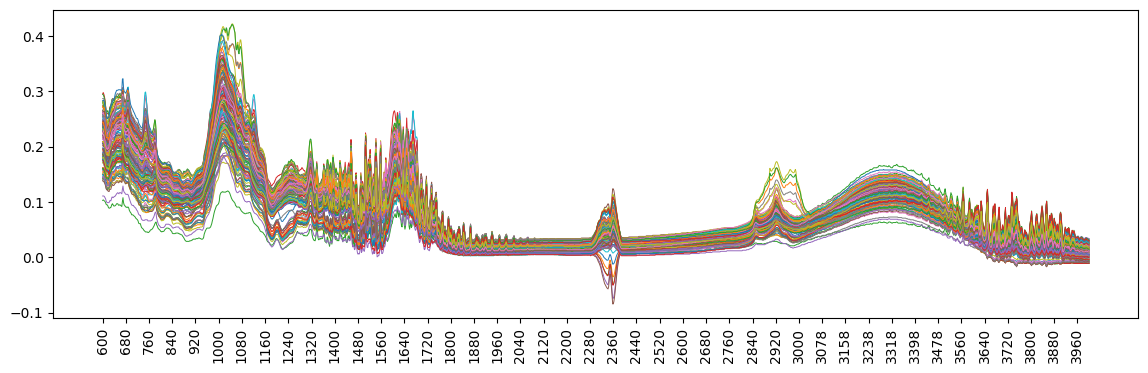

In [129]:
plt.figure(figsize=(14, 4))
plt.plot(X.T, linewidth= 0.7)
plt.xticks(X.columns[::40], rotation=90)
plt.show()

In [130]:
X.shape

(139, 1701)

In [131]:
X = savgol_filter(X, window_length=80, polyorder=5, deriv=0)

### Train test split

In [132]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (107, 1701) (107,)
Validation set shape: (32, 1701) (32,)


In [133]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [134]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input


In [135]:
import keras
from keras import layers


In [136]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [137]:
import tensorflow as tf
import random

tf.random.set_seed(1)
random.seed(1)
np.random.seed(1)

input_sig = layers.Input(shape=(X_train_scaled.shape[1], 1)) 
x = layers.Conv1D(128,3, activation='relu')(input_sig) 
x1 = layers.MaxPooling1D(2)(x) 
x2 = layers.Conv1D(64,3, activation='relu')(x1) 
x3 = layers.MaxPooling1D(2)(x2) 
flat = layers.Flatten()(x3) 
encoded = layers.Dense(24,activation = 'linear')(flat) 
 
 
# DECODER  
x2_ = layers.Conv1D(64, 3, activation='relu')(x3) 
x1_ = layers.UpSampling1D(2)(x2_) 
x_ = layers.Conv1D(128, 3, activation='relu')(x1_) 
upsamp = layers.UpSampling1D(2)(x_) 
flat = layers.Flatten()(upsamp) 
decoded = layers.Dense(X_train_scaled.shape[1],activation = 'linear')(flat) 
decoded = layers.Reshape((X_train_scaled.shape[1],1))(decoded) 
 

 
autoencoder = Model(input_sig, decoded) 
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse']) 

In [138]:
X_train_scaled.shape, X_test_scaled.shape

((107, 1701, 1), (32, 1701, 1))

In [139]:
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50,
                batch_size=36,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled))

Epoch 1/50
3/3 [==============================] - 128s 49s/step - loss: 0.3263 - mse: 0.3263 - val_loss: 0.1386 - val_mse: 0.1386
Epoch 2/50


KeyboardInterrupt: 

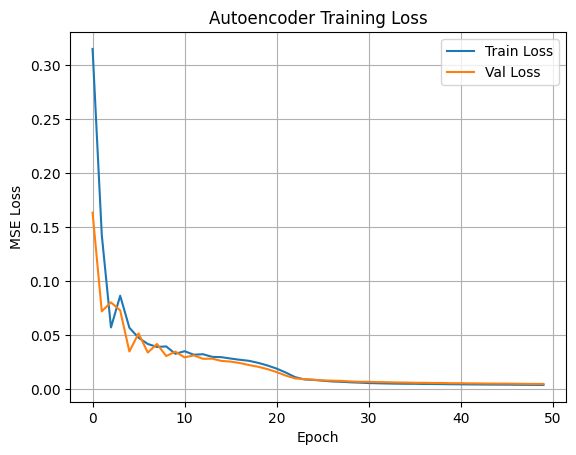

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create the encoder model
encoder = Model(input_sig, encoded)

# Get encoded representations
encoded_train = encoder.predict(X_train_scaled)
encoded_test = encoder.predict(X_test_scaled)


1/1 [==============================] - 0s 38ms/step


In [ ]:
scaler = MinMaxScaler()
encoded_train_scaled = scaler.fit_transform(encoded_train)
encoded_test_scaled = scaler.transform(encoded_test)

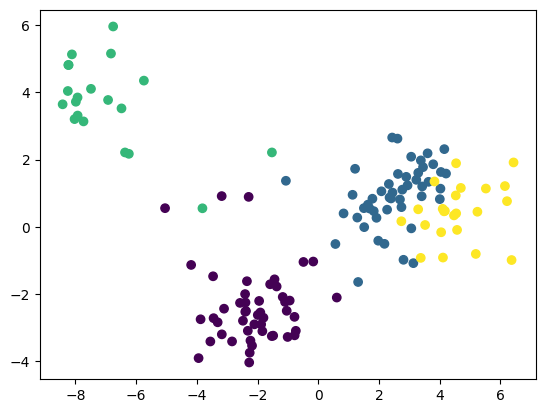

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# pca = PCA(10)
# X_train_pca = pca.fit_transform(encoded_train)
# X_test_pca = pca.transform(encoded_test)

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(encoded_train_scaled, y_train)
X_test_lda = lda.transform(encoded_test_scaled)

plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c = y_train)
plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c = y_test)
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
x1 = X_train_lda[:, 0]
y1 = X_train_lda[:, 1]
z1 = X_train_lda[:, 2]

x2 = X_test_lda[:, 0]
y2 = X_test_lda[:, 1]
z2 = X_test_lda[:, 2]


# Create a 3D scatter plot
fig = go.Figure()
# Add the first scatter trace
fig.add_trace(go.Scatter3d(
    x=x1,
    y=y1,
    z=z1,
    mode='markers',
    marker=dict(
        size=5,
        color=y_train,  # Color for the first set
        opacity=0.8
    ),
    # hovertemplate = hover_text_re,
))

fig.add_trace(go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        size=5,
        color=y_test,  # Color for the second set
        opacity=0.5
    ),
    # hovertemplate = hover_text_than,
))

# Set the layout of the plot
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width = 800,
    height = 600,
    title='Multiple 3D Scatter Plots Example'
)

# Show the plot
fig.show()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train_lda, y_train)
y_pred = svc.predict(X_test_lda)
accuracy_score(y_test, y_pred)

0.875

In [ ]:
encoded_train.shape

(107, 24)

In [ ]:
from sklearn.neural_network import MLPClassifier

ann = MLPClassifier(hidden_layer_sizes=[30,30], max_iter=4000, random_state=42)
ann.fit(encoded_train, y_train)
y_pred = ann.predict(encoded_test)
accuracy_score(y_test, y_pred)

0.875

In [ ]:
from sklearn.ensemble import RandomForestClassifier

ann = RandomForestClassifier()
ann.fit(encoded_train, y_train)
y_pred = ann.predict(encoded_test)
accuracy_score(y_test, y_pred)

0.71875

In [ ]:
from sklearn.svm import SVC

ann = SVC(kernel='linear')
ann.fit(encoded_train, y_train)
y_pred = ann.predict(encoded_test)
accuracy_score(y_test, y_pred)

0.6875

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

ann = GradientBoostingClassifier()
ann.fit(encoded_train, y_train)
y_pred = ann.predict(encoded_test)
accuracy_score(y_test, y_pred)

0.625